# $A_{\rm{eff}}$ in rate factor


In [44]:
import numpy as np
import stan_utility
from matplotlib import pyplot as plt
import corner

In [45]:
random_seed = 19920715

## Simple demonstration

Use an inhomogeneous poisson process over a simple 1D gaussian mixture. The events are marked with energies to give the simplest representation of what we were discussing in the Aachen meeting.

In [46]:
# Compile the model
sim = stan_utility.compile_model(filename = 'aeff_in_rate_factor_sim.stan', 
                                 model_name = 'aeff_in_rate_factor', 
                                 include_paths = 'stan/')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL aeff_in_rate_factor_5c65ccfb55d3ab92a571b10cd9ae20d8 NOW.


N:  150
weight:  [0.40677966 0.59322034]


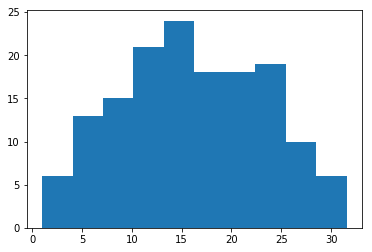

In [139]:
# Simulate
sim_input = {}
sim_input['Ncomp'] = 2
sim_input['mu'] = [10, 20]
sim_input['sigma'] = 5
sim_input['area_weight'] = [0.3, 0.7]
sim_input['Eth'] = [20, 50]
sim_input['Emax'] = 100
sim_input['dNdE'] = 3

simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed = random_seed)


location = simulation.extract('location')['location'][0]
energy = simulation.extract('energy')['energy'][0]
label = simulation.extract('label')['label'][0]
weight = simulation.extract('weight_out')['weight_out'][0]

fig, ax = plt.subplots()
ax.hist(location);
print('N: ', len(location))
print('weight: ', weight)

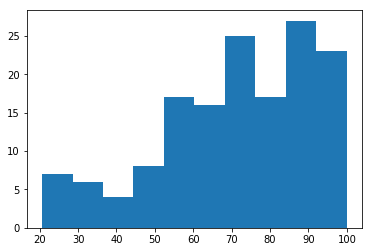

In [140]:
fig, ax = plt.subplots()
ax.hist(energy);

## Fit

In [141]:
# Compile the model
model = stan_utility.compile_model(filename = 'aeff_in_rate_factor_model.stan', 
                                   model_name = 'aeff_in_rate_factor', 
                                   include_paths = 'stan/')

Using cached StanModel


In [169]:
fit_input = {}
fit_input['Ncomp'] = sim_input['Ncomp']
fit_input['sigma'] = sim_input['sigma']
fit_input['Emax'] = sim_input['Emax']
fit_input['Eth'] = sim_input['Eth']
fit_input['dNdE'] = sim_input['dNdE']
fit_input['mu'] = sim_input['mu']
fit_input['area_weight'] = sim_input['area_weight']
fit_input['N'] = len(location)
fit_input['location'] = location
fit_input['energy'] = energy

fit_input['extra_factor'] = 0
fit_input['include_energy'] = 1

In [170]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

In [171]:
#fit

In [172]:
# View chains
#fig = fit.plot(['weight']);
#fig.set_size_inches(10, 5)
#fig.tight_layout()

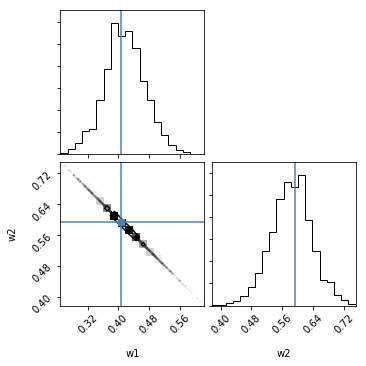

In [173]:
chain = fit.extract(permuted = True)
w = chain['weight'].T
corner.corner(np.column_stack([w[0], w[1]]), labels=['w1', 'w2'], 
              truths=[weight[0], weight[1]]);

## Association probability

In [174]:
# Calculate association probabilities for each source-neutrino combo
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]
Ns = np.shape(logprob)[1]
p = []
for lp in logprob:
    lps = []
    for src in range(Ns):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns):
        ps.append(lps[src] / norm)
    p.append(ps)

# Normalise line weights
pmax = max(max(p))

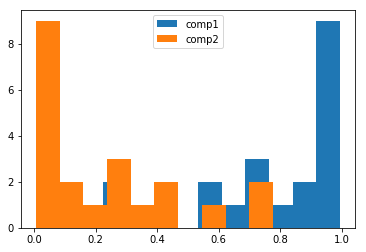

In [175]:
energy_below_th = energy[energy < sim_input['Eth'][1]]
inds = np.where(energy < sim_input['Eth'][1])[0]
p_select = [p[_] for _ in inds]

fig, ax = plt.subplots()
ax.hist(np.array(p_select).T[0], label='comp1')
ax.hist(np.array(p_select).T[1], label='comp2')
ax.legend();